In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees

from copy import copy


/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

In [175]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "lazyload"
env_name = "tree_layers7_bprob0.9_envs600000_H800_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
path_to_pkl = os.path.join(model_path, ckpt_name)

In [176]:
model_config = {
    "n_embd": 512,
    "n_layer": 3,
    "n_head": 4,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": 0,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [177]:
from src.models.transformer_end_query import Transformer
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_2891086/3170755486.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [5]:
eval_dataset_path = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/lazyload/tree_layers7_bprob1.0_envs600000_H1600_explore/datasets/eval.h5"
eval_trajs = h5py.File(eval_dataset_path, 'r')
traj_indices = list(eval_trajs.keys())
n_eval_envs = min(50, len(traj_indices))
random.seed(0)
traj_indices = random.sample(traj_indices, n_eval_envs)
random.seed()
eval_trajs = [eval_trajs[i] for i in traj_indices]


In [6]:
i_eval = 10
traj = eval_trajs[i_eval]

In [7]:
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding': 'random',
    'initialization_seed': np.array(traj['initialization_seed']).item()
}

In [8]:
env = EvalTrees().create_env(env_config, np.array(traj['goal']), i_eval)


# Run Model

In [178]:
layers = []
positions = []
state_features = []
state_features = list(env.node_map.keys())

for state_feature in state_features:
    layers.append(env.node_map[state_feature].layer)
    positions.append(env.node_map[state_feature].pos)

In [212]:
seq_length = 1000

In [213]:
hidden_states = [[] for _ in range(model.n_layer)]

state_feature = env.reset()

batch = {
    'context_states': convert_to_tensor([np.array(traj['context_states'])]),
    'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
    'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
    'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
    'query_states': convert_to_tensor([np.array(state_feature)]),
    }
batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
for k in batch.keys():
    if 'context' in k:
        batch[k] = batch[k][:,:seq_length]
    batch[k] = batch[k].to(model.device)
model.save_activations = True
with torch.no_grad():
    out = model(batch)

# Plotting Helper Functions

In [239]:
def plot_trajectory(
        states, next_states, query_state, attentions, env):
    fig, ax = plt.subplots(figsize=(10, 2))
    per_path_offset = 2**(env.max_layers+3)
    max_nodes_per_layer = 2**(env.max_layers)
    goal_node = env.node_map[tuple(env.goal.tolist())]
    goal_state = [goal_node.layer, goal_node.pos]
    query_state = copy(query_state)

    # Plot actual tree
    maze = []
    for node in env.node_map.values():
        maze.append([node.layer, node.pos])
    maze = np.array(maze).astype(float)
    base = 2*np.ones(maze.shape[0])
    nodes_per_layer = np.power(base, maze[:,0])
    offset_chunks = (4*max_nodes_per_layer)/(nodes_per_layer+1)
    maze[:,1] += offset_chunks*(maze[:,1]+1)
    ax.scatter(
        maze[:,1], -maze[:,0],
        c='gray', alpha=0.2, s=30, marker='x')
    
    # Mark query and goal node
    nodes_per_layer = np.power(2, query_state[0])
    offset_chunks = (4*max_nodes_per_layer)/(nodes_per_layer+1)
    query_state[1] += offset_chunks*(query_state[1]+1)
    ax.scatter(
        query_state[1], -query_state[0],
        c='green', alpha=1, s=50, marker='o')
    nodes_per_layer = np.power(2, goal_state[0])
    offset_chunks = (4*max_nodes_per_layer)/(nodes_per_layer+1)
    goal_state[1] += offset_chunks*(goal_state[1]+1)
    ax.scatter(
        goal_state[1], -goal_state[0],
        c='green', alpha=1, s=75, marker='*')
    
    attentions = attentions/np.percentile(attentions, 98)
    attentions = np.clip(attentions, 0, 1)

    for state, next_state, attention in zip(states, next_states, attentions):
        transition = np.stack([state, next_state], axis=0).astype(float)
        base = 2*np.ones(transition.shape[0])
        nodes_per_layer = np.power(base, transition[:,0])
        offset_chunks = (4*max_nodes_per_layer)/(nodes_per_layer+1)
        transition[:,1] += offset_chunks*(transition[:,1]+1)
        ax.plot(
            transition[:,1], -transition[:,0],
            alpha=attention,
            c='red'
        )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# Plot attention

In [215]:
states = []
next_states = []

state_features = batch['context_states'].cpu().numpy().squeeze()
next_state_features = batch['context_next_states'].cpu().numpy().squeeze()
for state_feature, next_state_feature in zip(state_features, next_state_features):
    state_feature = tuple(state_feature.tolist())
    next_state_feature = tuple(next_state_feature.tolist())
    states.append([
        env.node_map[state_feature].layer, env.node_map[state_feature].pos])
    next_states.append([
        env.node_map[next_state_feature].layer, env.node_map[next_state_feature].pos])
    
states = np.array(states)
next_states = np.array(next_states)

In [216]:
query_node = env.node_map[tuple(batch['query_states'].cpu().numpy().squeeze().tolist())]
query_state = [query_node.layer, query_node.pos]

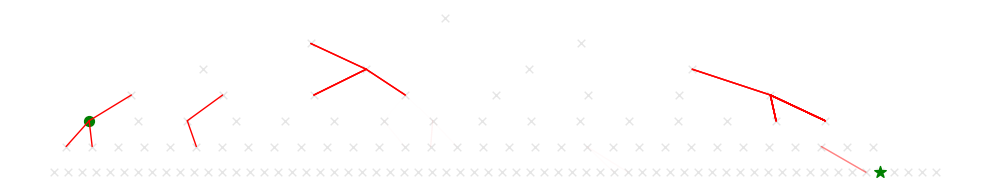

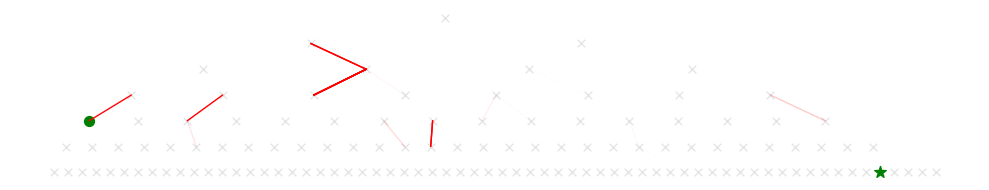

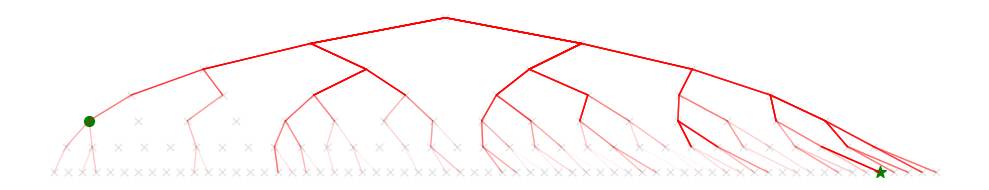

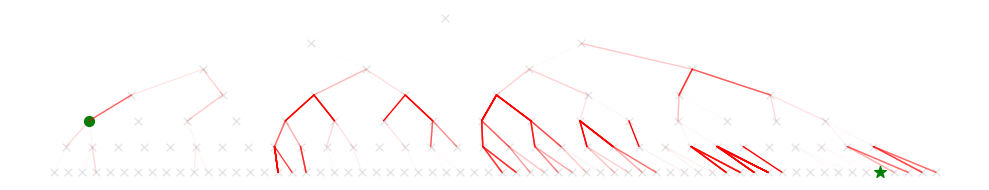

In [240]:
layer = 0
attn = model.activations['attentions'][layer].cpu().numpy().squeeze()
for head in range(model.n_head):
    plot_trajectory(states, next_states, query_state, attn[head, -1, :-1], env)


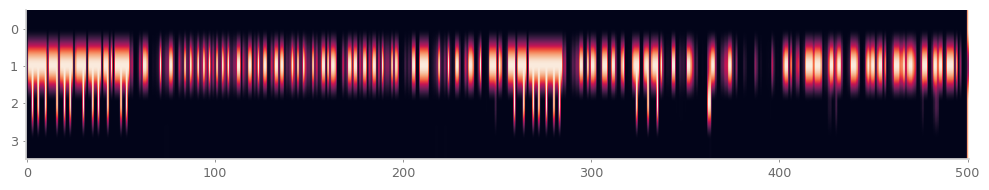

In [147]:
_attn = attn.copy()
_attn = _attn/np.percentile(_attn, 90)
_attn = np.clip(_attn, 0, 1)
plt.figure(figsize=(10,2))
plt.imshow(_attn[:,-1], aspect='auto')
plt.tight_layout()
plt.show()


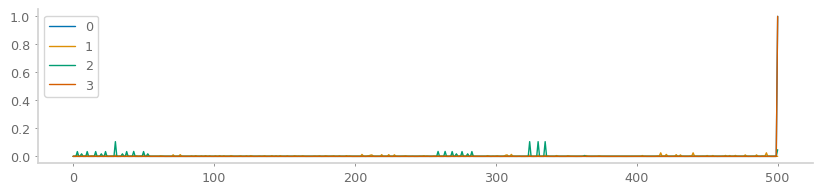

In [146]:
plt.figure(figsize=(10,2))
for layer in range(4):
    plt.plot(attn[layer,-1], label=layer)
plt.legend()
plt.show()
